Extracting ./data\train-images-idx3-ubyte.gz
Extracting ./data\train-labels-idx1-ubyte.gz
Extracting ./data\t10k-images-idx3-ubyte.gz
Extracting ./data\t10k-labels-idx1-ubyte.gz
(784,)


C:\Users\lychee\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


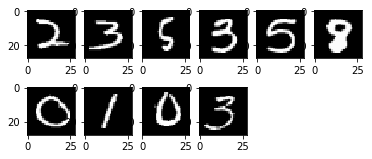

In [20]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np

#input: a list of images
def plotFigures(images):
    imageAmount = len(images)
    plt.figure(1)
    n_columns = 6
    n_rows = np.ceil(imageAmount/n_columns)+1
    sideLength = np.sqrt(len(images[0]))
    
    for i in range(imageAmount):
        plt.subplot(n_rows,n_columns,i+1)
        plt.imshow(np.reshape(images[i],[sideLength.astype(int),sideLength.astype(int)]),cmap="gray")
#end


mnist = input_data.read_data_sets('./data')
trainDatas = mnist.train.next_batch(10)
imageDatas = trainDatas[0]
labelDatas = trainDatas[1]
# print(imageDatas[0].shape)
# images = []
# for i in range(10):
#     images.append(imageDatas[i])
# plotFigures(images)
# plt.show()

#define a function to transform image dataset to batch set



In [ ]:
def fit_pca_shape(datasets,depth):
    factor=np.power(2,depth)
    length=32/factor
    print ('fit_pca_shape: length: {}'.format(length))
    idx1=range(0,int(length),2)
    idx2=[i+2 for i in idx1]
    print ('fit_pca_shape: idx1: {}'.format(idx1))
    data_lattice=[datasets[:,:,i:j,k:l] for ((i,j),(k,l)) in product(zip(idx1,idx2),zip(idx1,idx2))]
    data_lattice=np.array(data_lattice)
    print ('fit_pca_shape: data_lattice.shape: {}'.format(data_lattice.shape))

    #shape reshape
    data=np.reshape(data_lattice,(data_lattice.shape[0]*data_lattice.shape[1],data_lattice.shape[2],2,2))
    print ('fit_pca_shape: reshape: {}'.format(data.shape))
    return data


def PCA_and_augment(data_in,number_important):
    # data reshape
    data=np.reshape(data_in,(data_in.shape[0],-1))
    print( 'PCA_and_augment: {}'.format(data.shape))
    # mean removal
    mean = np.mean(data, axis=0)
    datas_mean_remov = data - mean
    print( 'PCA_and_augment meanremove shape: {}'.format(datas_mean_remov.shape))

    # PCA, retain all components
    pca=PCA(n_components = number_important)
    pca.fit(datas_mean_remov)
    comps=pca.components_

    # augment, DC component doesn't
    comps_aug=[vec*(-1) for vec in comps]
    comps_complete=np.vstack((comps,comps_aug))
    shapeComps = comps.shape
    mean_kernel = np.ones(shapeComps[1])
    mean_kernel = mean_kernel / np.sqrt(shapeComps[1])
    comps_complete = np.vstack((comps_complete,mean_kernel))
    print( 'PCA_and_augment comps_complete shape: {}'.format(comps_complete.shape))
    return comps,comps_complete

def one_stage_saak_trans(datasets=None,depth=0,number_important=3):

    print ('one_stage_saak_trans: datasets.shape {}'.format(datasets.shape))
    input_channels=datasets.shape[1]

    # change data shape, (14*60000,4)
    data_flatten=fit_pca_shape(datasets,depth)

    # augmented components
    comps,comps_complete=PCA_and_augment(data_flatten,number_important)
    print ('one_stage_saak_trans: comps_complete: {}'.format(comps_complete.shape))
    # print('one_saak_trans, non-aug kernel size:{}'.format(comps.shape))

    # get filter and datas, (7,1,2,2) (60000,1,32,32)
    filters=ret_filt_patches(comps_complete,input_channels)
    print ('one_stage_saak_trans: filters: {}'.format(filters.shape))

    # output (60000,7,14,14)
    relu_output,filt=conv_and_relu(filters,datasets,stride=2)

    data=relu_output.data.numpy()
    print ('one_stage_saak_trans: output: {}'.format(data.shape))
    return data,filt,relu_output
